In [1]:
import pandas as pd
import numpy as np
import torch
import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

from datasets import Dataset


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [4]:
df = pd.read_csv(
    "WELFake_Cleaned.csv",
    engine="python",
    on_bad_lines="skip"
)

print("Shape:", df.shape)
df.head()


Shape: (37991, 5)


,title,text,label,content,content_text
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,law enforcement high alert following threat co...
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,unbelievable obamas attorney general say charl...
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",bobby jindal raised hindu us story christian c...
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,satan russia unvelis image terrifying new supe...
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,About Time! Christian Group Sues Amazon and SP...,time christian group sue amazon splc designati...


In [11]:
# Remove rows with missing values
df = df.dropna(subset=["content", "label"])

# Convert label column to numeric
df["label"] = pd.to_numeric(df["label"], errors="coerce")

# Drop rows where label conversion failed
df = df.dropna(subset=["label"])

# Convert labels to integer
df["label"] = df["label"].astype(int)

print("Unique labels:", df["label"].unique())
print("Dataset shape after label cleaning:", df.shape)


Unique labels: [1 0]
Dataset shape after label cleaning: (37944, 5)


In [12]:
# Features and labels
X = df['content_text']
y = df['label']

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [13]:
train_dataset = Dataset.from_dict({
    "text": list(X_train),
    "label": list(y_train)
})

test_dataset = Dataset.from_dict({
    "text": list(X_test),
    "label": list(y_test)
})


In [14]:
model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2
)

model.to(device)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
pre_classifier.bias     | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSelfAttention(
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [15]:
def tokenize_function(example):
    return tokenizer(
        example["text"],
        padding="max_length",
        truncation=True,
        max_length=256
    )

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

train_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)

test_dataset.set_format(
    type="torch",
    columns=["input_ids", "attention_mask", "label"]
)


Map:   0%|          | 0/30355 [00:00<?, ? examples/s]

Map:   0%|          | 0/7589 [00:00<?, ? examples/s]

In [16]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)

    return {
        "accuracy": acc,
        "f1": f1
    }


In [17]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    save_total_limit=1,
    report_to="none"
)


`logging_dir` is deprecated and will be removed in v5.2. Please set `TENSORBOARD_LOGGING_DIR` instead.


In [18]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)


In [19]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.092426,0.081971,0.975623,0.973991
2,0.029730,0.067205,0.983265,0.982295


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=3796, training_loss=0.07811573307933747, metrics={'train_runtime': 1655.8734, 'train_samples_per_second': 36.663, 'train_steps_per_second': 2.292, 'total_flos': 4021047886202880.0, 'train_loss': 0.07811573307933747, 'epoch': 2.0})

In [20]:
predictions = trainer.predict(test_dataset)

y_pred = np.argmax(predictions.predictions, axis=1)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Final Accuracy:", accuracy)
print("Final F1 Score:", f1)

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


Final Accuracy: 0.9832652523389116
Final F1 Score: 0.9822947162972258

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4004
           1       0.98      0.98      0.98      3585

    accuracy                           0.98      7589
   macro avg       0.98      0.98      0.98      7589
weighted avg       0.98      0.98      0.98      7589



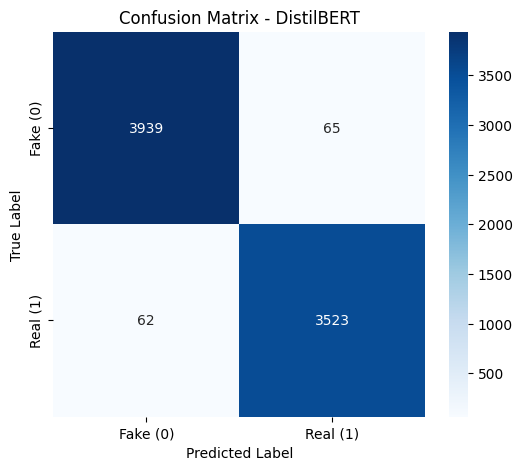

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=["Fake (0)", "Real (1)"],
            yticklabels=["Fake (0)", "Real (1)"])

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - DistilBERT")
plt.show()


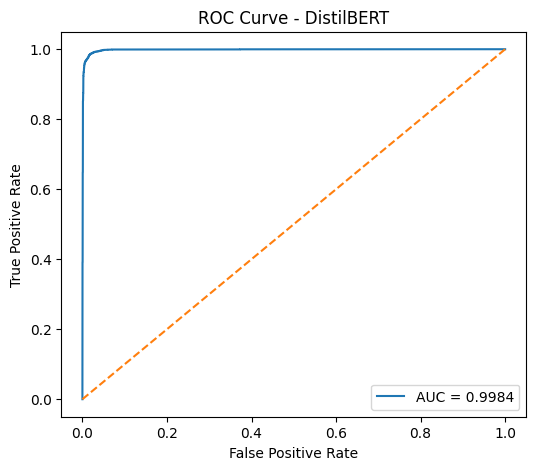

AUC Score: 0.9983648499338875


In [22]:
from sklearn.metrics import roc_curve, roc_auc_score

# Get probabilities for class 1
y_probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
auc_score = roc_auc_score(y_test, y_probs)

# Plot ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}")
plt.plot([0,1], [0,1], linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - DistilBERT")
plt.legend()
plt.show()

print("AUC Score:", auc_score)


In [23]:
save_path = "./distilbert_fake_news_model"

trainer.save_model(save_path)
tokenizer.save_pretrained(save_path)

print("Model saved successfully!")


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model saved successfully!


In [24]:
!zip -r distilbert_fake_news_model.zip distilbert_fake_news_model


  adding: distilbert_fake_news_model/ (stored 0%)
  adding: distilbert_fake_news_model/config.json (deflated 49%)
  adding: distilbert_fake_news_model/model.safetensors (deflated 8%)
  adding: distilbert_fake_news_model/tokenizer.json (deflated 71%)
  adding: distilbert_fake_news_model/tokenizer_config.json (deflated 42%)
  adding: distilbert_fake_news_model/training_args.bin (deflated 53%)
